## ACP 166: Datos abiertos para ciudades resilientes
### Unidad 2: Datos abiertos para ciudades y clima
#### 5 de noviembre 2025

En esta lección, consideraremos una serie de conjuntos de datos de código abierto relacionados con la exposición poblacional. Compararemos datos del INDEC argentino, GHSL y huellas de edificios abiertas para intentar estimar la población en asentamientos informales alrededor de La Plata. En particular, intentaremos comprender los propios conjuntos de datos: cómo y cuándo se elaboraron, qué contienen, quién los mantiene y, fundamentalmente, qué tan confiables son.

## Sección 1: Población en barrios populares

In [1]:
import geopandas as gpd
from io import BytesIO
import os
from owslib.wfs import WebFeatureService
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterstats

# constantes de CRS
USE_CRS = "EPSG:5348"  # POSGAR 2007 / Argentina 4
WEB_MERCATOR_CRS = "EPSG:3857"  # visualización
WGS84_CRS = "EPSG:4326"  # consultas API

### 1.1 Datos RENABAP

Para comenzar, importaremos la fuente de datos oficial de Argentina sobre asentamientos informales: el Registro Nacional de Barrios Populares (RENABAP). Según [su documentación](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/observatorio-de-barrios-populares), incluyen información sobre límites geográficos y datos sociodemográficos, y se basan en relevamientos barriales bajo la dirección de la Subsecretaría de Integración Socio Urbana, con el apoyo de RENAPER y ANSES.

Una observación importante sobre estos datos es que la versión más reciente (2023) se calculó utilizando _proyecciones_ basadas en los datos del censo nacional argentino de 2010. Dada la rapidez con la que pueden cambiar los asentamientos informales, esto plantea la posibilidad de que las estimaciones estén significativamente desfasadas con respecto a la situación real--que es precisamente lo que exploraremos en este taller.

Obtendremos nuestros datos de RENABAP de un archivo GeoJSON estático disponible en https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson. Curiosamente, no hay una API pública ni un botón de descarga para estos datos; en cambio, pueden encontrarse en el código fuente de la página del [mapa web público de RENABAP de asentamientos informales](https://www.argentina.gob.ar/obras-publicas/sisu/renabap/mapa):

![RENABAP map source](/home/nissim/Documents/dev/datos-escala-humana/public/renabap-mapa-source.png)

Como los datos están disponibles como un archivo plano (un conjunto de datos único y estático que se descarga, en lugar de un servidor o base de datos que se consulta dinámicamente), podemos cargarlos directamente desde esta URL usando `GeoPandas`.

In [ ]:
renabap_ruta = (
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)

# TODO: cargar los datos de RENABAP directamente usando geopandas
renabap = gpd.read_file(renabap_ruta)

# TODO: filtrar por la columna "provincia" para datos de Buenos Aires
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]

# TODO: reproyectar los datos al USE_CRS
renabap_pba = renabap_pba.to_crs(USE_CRS)

En teoría, tenemos una idea general de qué contiene el conjunto de datos, gracias a la documentación de RENABAP. Pero para entenderlo realmente, tenemos que realizar un _análisis exploratorio de datos_ (o "EDA"). Comenzaremos revisando lo básico: el tamaño de los datos, cómo se ven las primeras filas y cuáles son las distribuciones de los datos.

In [ ]:
# TODO: revisar el tamaño de los datos
renabap_pba.shape

(2065, 7)

In [ ]:
# TODO: imprimir las primeras 5 filas de los datos
# TODO: ¿qué columnas tiene? ¿cuál es el tipo de datos en cada columna?
renabap_pba.head()

,id_renabap,nombre_barrio,provincia,departamento,localidad,familias_aproximadas,geometry
0,1,Monterrey I,Buenos Aires,Pilar,Presidente Derqui,44,"MULTIPOLYGON (((6331563.369 6183392.384, 63315..."
1,2,Malvinas II,Buenos Aires,La Plata,José Melchor Romero,319,"MULTIPOLYGON (((6407555.589 6132750.136, 64078..."
2,3,Ferroviario,Buenos Aires,La Plata,Angel Etcheverry,146,"MULTIPOLYGON (((6401466.885 6122949.29, 640148..."
3,4,La Favelita,Buenos Aires,La Plata,Tolosa,134,"MULTIPOLYGON (((6410444.382 6137104.402, 64104..."
4,5,Casaca,Buenos Aires,La Plata,City Bell,22,"MULTIPOLYGON (((6402845.212 6137802.877, 64028..."


Entonces, ¿cuántos nombres _únicos_ hay para los barrios? ¿Cuántos asentamientos hay por departamento? ¿Y por localidad? ¿Cuál es el número promedio de familias por barrio? ¿Mínimo? ¿Máximo? ¿Total?

In [ ]:
# TODO: ¿cuántos nombres únicos de barrios hay?
print(f"Nombres únicos de barrios: {renabap_pba['nombre_barrio'].nunique()}")

# TODO: ¿cuántos asentamientos hay por departamento? ¿por localidad?
print("\nAsentamientos por departamento:")
print(renabap_pba.groupby("departamento").size())
print("\nAsentamientos por localidad:")
print(renabap_pba.groupby("localidad").size())

# TODO: ¿cuál es el número promedio de familias por barrio? ¿mínimo? ¿máximo? ¿total?
print("\nEstadísticas de familias aproximadas:")
print(f"Promedio: {renabap_pba['familias_aproximadas'].mean():.2f}")
print(f"Mínimo: {renabap_pba['familias_aproximadas'].min()}")
print(f"Máximo: {renabap_pba['familias_aproximadas'].max()}")
print(f"Total: {renabap_pba['familias_aproximadas'].sum()}")
print("\nResumen estadístico completo:")
print(renabap_pba.describe())

Nombres únicos de barrios: 1507

Asentamientos por departamento:
departamento
25 de Mayo          4
9 de Julio          3
Almirante Brown    74
Arrecifes           5
Avellaneda         45
                   ..
Tres de Febrero    20
Vicente López      15
Villa Gesell        8
Villarino          13
Zárate             36
Length: 90, dtype: int64

Asentamientos por localidad:
localidad
Abasto                   4
Aldo Bonzi               1
Alejandro Korn          14
Altos De San Lorenzo    14
Angel Etcheverry         5
                        ..
Wilde                    1
William Morris          10
Zelaya                   1
Zona De Reserva          2
Zárate                  30
Length: 295, dtype: int64

Estadísticas de familias aproximadas:
Promedio: 285.12
Mínimo: 9
Máximo: 8635
Total: 588779

Resumen estadístico completo:
        id_renabap  familias_aproximadas
count  2065.000000           2065.000000
mean   2082.995157            285.123002
std    2062.617169            513.854272
min 

Ahora, usaremos el mismo conjunto de datos de partidos del taller anterior para obtener los límites de La Plata.

In [ ]:
# Cargar partidos desde el servicio WFS de ARBA GeoServer
if os.path.exists("pba_partidos.geojson"):
    partidos = gpd.read_file("pba_partidos.geojson")
else:
    # Conectar al servicio WFS (Web Feature Service)
    wfs_url = "https://geo.arba.gov.ar/geoserver/idera/wfs"
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Solicitar la capa de Departamento (partidos)
    response = wfs.getfeature(
        typename="idera:Departamento",
        srsname="EPSG:5347",  # CRS original
    )

    # Convertir respuesta WFS a GeoDataFrame
    partidos = gpd.read_file(BytesIO(response.read()))

    # Guardar en caché para uso futuro
    partidos.to_file("pba_partidos.geojson", driver="GeoJSON")

# Reproyectar al CRS de trabajo
partidos = partidos.to_crs(USE_CRS)

la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

# Obtener la geometría principal y mantener solo el polígono más grande
# Esto elimina pequeñas islas que aparecen en los datos
la_plata = la_plata.copy()
main_geom = la_plata.geometry.iloc[0]
la_plata.loc[la_plata.index[0], "geometry"] = max(main_geom.geoms, key=lambda p: p.area)

Al igual que con las cuencas en el taller anterior, filtraremos los asentamientos informales que _intersectan_ con los límites de La Plata. Es importante hacer esto y no _recortar_ (lo cual truncaría nuestros asentamientos informales cortando literalmente partes de ellos), o elegir el predicado espacial incorrecto como "dentro de", lo cual excluiría asentamientos que no caen 100% dentro de los límites de La Plata. Dado que los asentamientos informales suelen ocurrir en el borde de los asentamientos formales, esto es especialmente importante.

In [ ]:
renabap_la_plata = renabap_pba[
    renabap_pba.geometry.intersects(
        la_plata.union_all()
    )  # union_all() combina todas las geometrías de La Plata en caso de que haya múltiples polígonos
].copy()  # .copy() crea una copia independiente para evitar advertencias al modificar

Ahora, vamos a visualizar nuestros datos. Nos aseguraremos de incluir los límites de La Plata para contexto, y agregaremos un paso adicional: colorear los asentamientos informales según el número de familias que tienen según RENABAP.

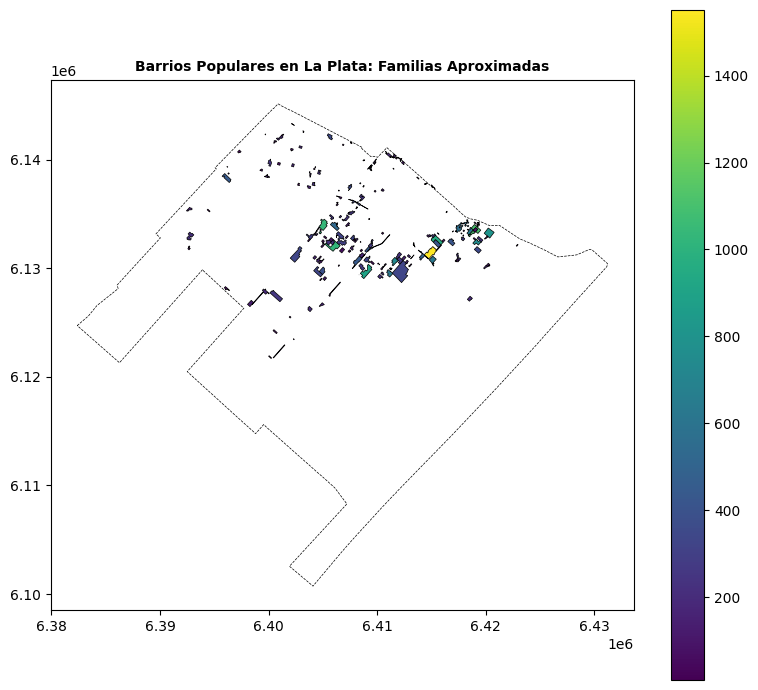

In [ ]:
# TODO: visualizar los asentamientos informales de La Plata
#       - agregar los límites de La Plata para contexto
#       - colorear usando la columna "familias_aproximadas"
#       - incluir una leyenda y un titulo descriptivo
#       - experimentá con diferentes colormaps y estilos de borde


fig, ax = plt.subplots(figsize=(8, 7))


renabap_la_plata.plot(
    "familias_aproximadas",
    ax=ax,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.5,
)

la_plata.boundary.plot(ax=ax, color="black", linewidth=0.5, linestyle="--")

ax.set_title(
    "Barrios Populares en La Plata: Familias Aproximadas",
    fontsize=10,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

Ahora que hemos filtrado para La Plata, podemos comenzar a realizar estadísticas descriptivas más significativas. Nuevamente, analizaremos la _distribución_ de la población estimada en asentamientos informales _solo en el área de La Plata_.

In [ ]:
# TODO: calcular estadísticas descriptivas de la columna "familias_aproximadas"
renabap_la_plata["familias_aproximadas"].describe()

count     167.000000
mean      203.131737
std       238.285607
min         9.000000
25%        46.000000
50%       132.000000
75%       252.000000
max      1551.000000
Name: familias_aproximadas, dtype: float64

Un histograma puede ayudarnos a obtener una mejor idea de la distribución. Un histograma es un gráfico que muestra la frecuencia de valores en diferentes rangos, permitiéndonos visualizar cómo se distribuyen los datos.

array([[<Axes: title={'center': 'familias_aproximadas'}>]], dtype=object)

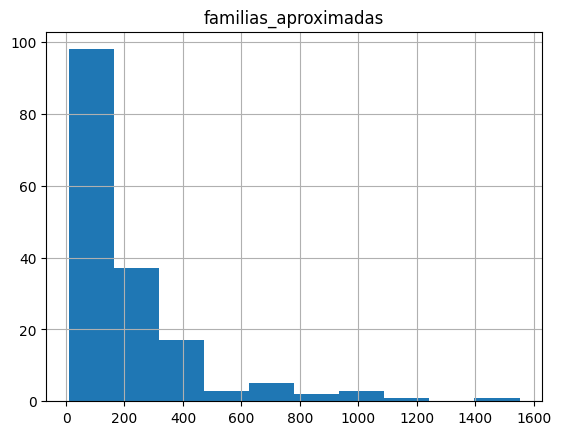

In [ ]:
# TODO: crear un histograma de la columna "familias_aproximadas" para visualizar su distribución
renabap_la_plata.hist("familias_aproximadas")

También podemos mostrar los nombres de los barrios más grandes y más pequeños.

In [ ]:
# TODO: imprimir el nombre y el número de familias del barrio más grande y del más pequeño basado en la columna 'familias_aproximadas'

largest = renabap_la_plata.loc[renabap_la_plata["familias_aproximadas"].idxmax()]
print(
    f"Barrio más grande: {largest['nombre_barrio']} ({largest['familias_aproximadas']} familias)"
)

smallest = renabap_la_plata.loc[renabap_la_plata["familias_aproximadas"].idxmin()]
print(
    f"Barrio más pequeño: {smallest['nombre_barrio']} ({smallest['familias_aproximadas']} familias)"
)

Barrio más grande: Puente de Fierro (1551 familias)
Barrio más pequeño: La Hermosura (9 familias)


Ahora tenemos una buena idea de qué contiene el conjunto de datos de RENABAP. Sin embargo, como recordamos, la metodología utilizada para producir los datos nos da razones para creer que estos datos pueden no ser muy precisos. A continuación, recurriremos a un conjunto de datos de población global como nuestro primer punto de comparación.

### 1.2 Datos GHSL

Existen varios conjuntos de datos globales que pueden darnos información sobre patrones de población. Algunos de los comúnmente utilizados en análisis de riesgo climático incluyen la Capa Global de Asentamientos Humanos (GHSL), WorldPop y la Capa de Asentamientos de Alta Resolución. Estos conjuntos de datos típicamente se derivan de una combinación de imágenes satelitales y datos auxiliares, como edificios y carreteras globales o luces nocturnas, y se estiman usando modelos de aprendizaje automático. Cada uno de estos conjuntos de datos tiene ventajas y limitaciones: algunos tienen mayor resolución o mejor cobertura temporal o mejor consistencia metodológica. Aquí, usaremos GHSL porque era el conjunto de datos con la mayor resolución y mejor cobertura temporal disponible en el momento de la escritura, además de ser el conjunto de datos elegido por Floodbase, una compañía global de riesgo de inundaciones [@tellman2021].

La [Capa Global de Asentamientos Humanos (Global Human Settlement Layer)](https://human-settlement.emergency.copernicus.eu/ghs_pop2023.php) [@ghsl_pop2023a] es un conjunto de datos de resolución de 100 metros que proporciona estimaciones de población multitemporales (1975-2030) derivadas de datos censales y administrativos, informadas por la distribución y clasificación de áreas construidas. Para este análisis se utilizan los datos GHSL de 2023, que son los más recientes disponibles. Sin embargo, note que estos fueron publicados en 2023, lo que significa que también son _proyecciones_, no estimaciones de 2025 en sí.

Aquí, importaremos los datos GHSL desde un GeoTIFF optimizado para la nube, que es un formato de archivo diseñado para el acceso eficiente de conjuntos de datos almacenados remotamente. Para nuestros propósitos, esto significa que es fácil cargarlos directamente sin usar mucha memoria o tener que descargar un archivo local.

In [28]:
import requests

# Test if you can reach the server
response = requests.head("https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/")
print(response.status_code)

ConnectionError: HTTPSConnectionPool(host='jeodpp.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /ftp/jrc-opendata/GHSL/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7393951a0f80>: Failed to resolve 'jeodpp.jrc.ec.europa.eu' ([Errno -3] Temporary failure in name resolution)"))

In [27]:

# Direct URL to the TIF (if it exists unzipped on the server)
ghsl_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif"

ghsl = rio.open_rasterio(
    ghsl_url,
    chunks={"x": 2048, "y": 2048},
)

# Get bounds and transform them to GHSL's CRS first
bounds = renabap_la_plata.total_bounds
bounds_ghsl_crs = renabap_la_plata.to_crs(ghsl.rio.crs).total_bounds

# Clip FIRST (in original CRS)
ghsl_clipped = ghsl.rio.clip_box(
    minx=bounds_ghsl_crs[0],
    miny=bounds_ghsl_crs[1],
    maxx=bounds_ghsl_crs[2],
    maxy=bounds_ghsl_crs[3],
)

# Then reproject the smaller clipped area
ghsl_clipped = ghsl_clipped.rio.reproject(dst_crs=USE_CRS)

# Handle no-data values
ghsl_clipped = ghsl_clipped.where(ghsl_clipped > -200)

RasterioIOError: CURL error: Could not resolve host: jeodpp.jrc.ec.europa.eu

Here's an important note. We recall that there are some informal settlements that do not fall completely within the official boundaries of the Partido. Therefore, if we simply clip the GHSL data to the boundaries of La Plata, we will actually be cutting out population that should be counted as part of the informal settlements! To address this, we'll clip by the bounding box of the informal settlements: the smallest rectangle that completely encompasses all the settlements. This will make sure we're not accidentally undercounting the population.

In [117]:
# Clip to the total bounds of the informal settlements
bounds = renabap_la_plata.total_bounds
ghsl_clipped = ghsl.rio.clip_box(
    minx=bounds[0],
    miny=bounds[1],
    maxx=bounds[2],
    maxy=bounds[3],
)

# Properly handle no-data values (-200) while keeping xarray structure
ghsl_clipped = ghsl_clipped.where(ghsl_clipped > -200)

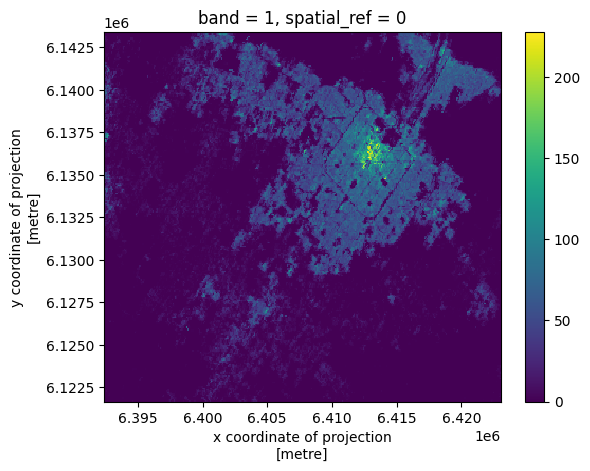

In [118]:
ghsl_clipped.plot()

Now, to summarize GHSL estimated population per informal settlements, we can use _zonal statistics_, a tool we saw in the previous workshop. Zonal statistics allows us to compute various descriptive statistics (e.g., min, mean, sum, etc.) for a the part of a raster that falls within certain vector data. In this case, we want to calcualte the _sum_ of the GHSL population estimates within each informal settlement.

One important quirk of zonal statistics is how they handle cells that _partially_ intersect with a given neighborhood. Do they include the value of the cell in the sum or not? Here, we'll calcualte it both ways: one column, `ghsl_pop_est_alta`, that _includes_ these values, and one column, `ghsl_pop_est_alta`, that _excludes_ them. How do you think these decisions will impact the estimated population totals per settlement?

In [119]:
# Set no-data values to 0, keep all valid population values
ghsl_final = ghsl_clipped.where(ghsl_clipped > -200, 0)

# Extract geometries for zonal statistics
barrio_geometries = [geom for geom in renabap_la_plata.geometry]

# Calculate zonal statistics for GHSL population (high estimate - all touched)
ghsl_stats_alta = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_final.values[0],
    affine=ghsl_final.rio.transform(),
    stats=["sum"],
    nodata=0,
    all_touched=True,
)

# Calculate zonal statistics for GHSL population (low estimate - only center)
ghsl_stats_baja = rasterstats.zonal_stats(
    barrio_geometries,
    ghsl_final.values[0],
    affine=ghsl_final.rio.transform(),
    stats=["sum"],
    nodata=0,
    all_touched=False,
)

# Add both GHSL population estimates to renabap_la_plata
ghsl_sums_alta = [
    stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_alta
]
ghsl_sums_baja = [
    stat["sum"] if stat["sum"] is not None else 0 for stat in ghsl_stats_baja
]

renabap_la_plata["ghsl_pop_est_alta"] = ghsl_sums_alta
renabap_la_plata["ghsl_pop_est_baja"] = ghsl_sums_baja

In [120]:
print(renabap_la_plata["ghsl_pop_est_alta"].sum())
print(renabap_la_plata["ghsl_pop_est_baja"].sum())

151776.197692425
89267.32096357644


In [121]:
print(renabap_la_plata["ghsl_pop_est_alta"].describe())

count     167.000000
mean      908.839507
std      1032.947544
min         6.602923
25%       262.911765
50%       553.785965
75%      1258.653251
max      5237.717794
Name: ghsl_pop_est_alta, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_alta'}>]], dtype=object)

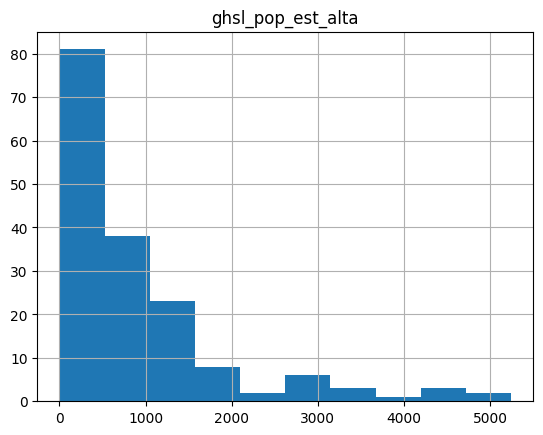

In [122]:
renabap_la_plata.hist("ghsl_pop_est_alta")

In [123]:
print(renabap_la_plata["ghsl_pop_est_baja"].describe())

count     167.000000
mean      534.534856
std       762.225092
min         0.000000
25%        85.027544
50%       252.472338
75%       731.548264
max      4347.947598
Name: ghsl_pop_est_baja, dtype: float64


array([[<Axes: title={'center': 'ghsl_pop_est_baja'}>]], dtype=object)

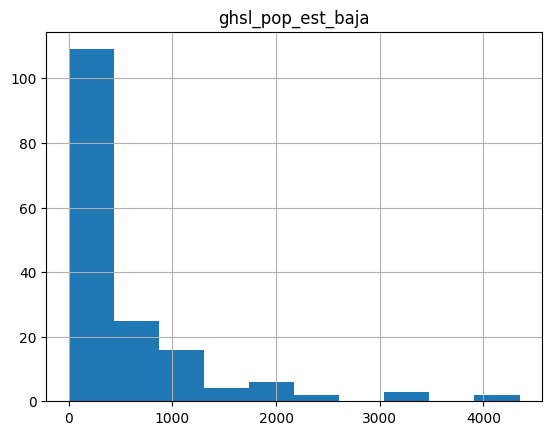

In [124]:
renabap_la_plata.hist("ghsl_pop_est_baja")

We can now compare these data to the RENABAP population estimates. Here, it's important to bear in mind that RENABAP reports _families_, while GHSL reports _population_. Thus, while we expect these numbers to be _proportional_ to one another, we would expect GHSL's estimates to be higher (probably about 3x higher, assuming roughly 3 people per family).

In [125]:
print(
    renabap_la_plata["ghsl_pop_est_alta"].sum()
    / renabap_la_plata["familias_aproximadas"].sum()
)
print(
    renabap_la_plata["ghsl_pop_est_baja"].sum()
    / renabap_la_plata["familias_aproximadas"].sum()
)

4.474138422086048
2.6314689433003107


One tool that we can use here is calculation the _correlation coefficient_, which measures the strength of the relationship between these two variables. These values range from 0 to 1, with those closer to 1 indicating a strong relationship. The p-value indicates how confident we are in the significance of these relationships (we're looking for p-values of 0.05 or lower). Here, we're using Spearman's correlation coefficient (rather than Pearson's) because it's better suited to messy data.

In this case, we see that both GHSL columns have _strong_ correlations with the RENABAP data, indicating that they are closely related. This does _not_ mean that they agree on the actual number of people per barrio, but that [what does this actually mean]?

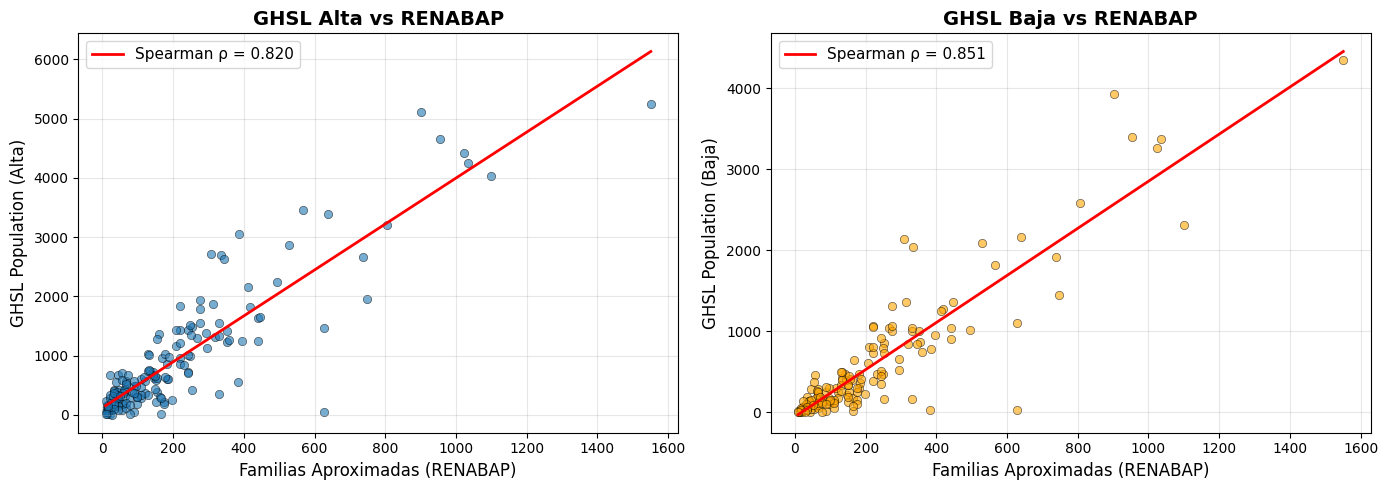

GHSL Alta vs RENABAP Familias:
  Spearman ρ = 0.8196
  p-value = 9.21e-42

GHSL Baja vs RENABAP Familias:
  Spearman ρ = 0.8509
  p-value = 5.50e-48


In [126]:
import matplotlib.pyplot as plt
from scipy import stats

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: GHSL Alta vs RENABAP Families
ax1 = axes[0]
ax1.scatter(
    renabap_la_plata["familias_aproximadas"],
    renabap_la_plata["ghsl_pop_est_alta"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)

# Spearman correlation for GHSL alta vs families
rho1, p_value1 = stats.spearmanr(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_alta"]
)

# Add regression line for reference
slope1, intercept1 = np.polyfit(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_alta"], 1
)
x1 = np.array(
    [
        renabap_la_plata["familias_aproximadas"].min(),
        renabap_la_plata["familias_aproximadas"].max(),
    ]
)
ax1.plot(
    x1, intercept1 + slope1 * x1, "r-", linewidth=2, label=f"Spearman ρ = {rho1:.3f}"
)

ax1.set_xlabel("Familias Aproximadas (RENABAP)", fontsize=12)
ax1.set_ylabel("GHSL Population (Alta)", fontsize=12)
ax1.set_title("GHSL Alta vs RENABAP", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: GHSL Baja vs RENABAP Families
ax2 = axes[1]
ax2.scatter(
    renabap_la_plata["familias_aproximadas"],
    renabap_la_plata["ghsl_pop_est_baja"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
    color="orange",
)

# Spearman correlation for GHSL baja vs families
rho2, p_value2 = stats.spearmanr(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_baja"]
)

# Add regression line for reference
slope2, intercept2 = np.polyfit(
    renabap_la_plata["familias_aproximadas"], renabap_la_plata["ghsl_pop_est_baja"], 1
)
x2 = np.array(
    [
        renabap_la_plata["familias_aproximadas"].min(),
        renabap_la_plata["familias_aproximadas"].max(),
    ]
)
ax2.plot(
    x2, intercept2 + slope2 * x2, "r-", linewidth=2, label=f"Spearman ρ = {rho2:.3f}"
)

ax2.set_xlabel("Familias Aproximadas (RENABAP)", fontsize=12)
ax2.set_ylabel("GHSL Population (Baja)", fontsize=12)
ax2.set_title("GHSL Baja vs RENABAP", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed stats
print("GHSL Alta vs RENABAP Familias:")
print(f"  Spearman ρ = {rho1:.4f}")
print(f"  p-value = {p_value1:.2e}\n")

print("GHSL Baja vs RENABAP Familias:")
print(f"  Spearman ρ = {rho2:.4f}")
print(f"  p-value = {p_value2:.2e}")



Now who else should notice there are some strong outliers.

There are several neighborhoods where the population difference is really big.

We can actually estimate the population, we sort of take this average and multiply by families.

We can actually estimate the difference in population estimates between the two of them.

So we can kind of highlight some of these audios where there's the biggest disagreement between our two data sets.

And sort of say these are probably worth looking into.

Again, it's important to note that we need to look at percent disagreement, not just total disagreement, because I disagree with three families in a row with 5,000 families is less important than the disagreement of 50 families.

The disagreement of 50 families in a row of 4,000 families is less important than a disagreement of 50 families in a row of 500 families.

So we can do the percent disagreement between them two.

We can also now pass to, so we can sort of highlight these neighborhoods that have kind of big discrepancies here.

But generally, these two data seem to suggest roughly similar number of population.

So the RENABAP and GHSL data generally agree on roughly the number of people per barrio, which should give us some confidence in the data. However, we're now going to look at a third dataset that should raise some major doubts.

### 1.3 Datos de edificaciones

In recent years, a new type of population dataset has emerged: building footprints. Building footprints are derived from high-resolution satellite imagery using deep learning and show the two-dimension shape of a building (although newer datasets also include height). 

![Building footprint extraction (Source: Microsoft)](/home/nissim/Documents/dev/datos-escala-humana/public/segmentation.jpg)

(Source: [Microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints/blob/main/images/segmentation.jpg))

Companies and non-profits like Google, Microsoft, and Open Street Map have all produced their own building footprint datasets for various parts of the world. The climate tech company VIDA has produced [a combined, standardized version of these datasets](https://source.coop/repositories/vida/google-microsoft-osm-open-buildings/access) [@google_microsoft_osm_buildings] and open sourced it via Source Cooperative. At 2.75 billion footprints, this is the most comprehensive currently-available dataset, and therefore what we'll be using today. 

Estos datos han sido utilizados en evaluaciones de riesgo de inundación por [empresas globales de riesgo financiero, como ICE](https://www.ice.com/insights/sustainable-finance/ice-climates-exposure-datasets-understanding-how-climate-risks-impact-infrastructure-and-communities), demostrando su utilidad para mapear la exposición climática a nivel de huella individual. Su resolución espacial permite estimar con mayor detalle la distribución de las estructuras habitacionales en el área analizada. Building footprints also have the advantage of being pretty easy to validate: the user can simply check the most recent available satellite imagery basemaps and confirm that the building is there as indicated, which makes them a fairly trustworthy dataset.

One obstacle to estimating population based on building footprints alone is that buildings come in many different types and sizes: some have one floor and some have seven or fifteen of forty, and some are residential and some are commercial and some are industrial, none of which you would know from a footprint alone. But informal settlements are kind of unique in this respect. They tend not to have a lot of formal commercial buildings, and few (if any) multi-story buildings. It's generally safe to assume that--for the most part--informal settlements have roughly one family per building. This was something I also confirmed in conversations with municipal GIS officials here in La Plata, just to be safe. So, in our analysis of building footprints in informal settlements in La Plata, we _expect_ the number of building footprints to more or less match the number of families estimated by RENABAP.

The data we're using from VIDA are stored as GeoParquet files, which is [a cloud-optimized vector data format](https://guide.cloudnativegeo.org/geoparquet/). What that means for us is that we can use a tool like DuckDB to very efficiently process _all_ the building footprints in Argentina, filtering them to _only_ load the ones we actually care about--the ones in La Plata!

In [129]:
import duckdb
import pandas as pd

This query should run in about 2 minutes--pretty crazy given that it's filtering _33.75 million_ building footprints in Argentina! And this is actually the slow approach--we could speed things up by using [the S2-partitioned version of the dataset](https://source.coop/vida/google-microsoft-open-buildings/geoparquet/by_country_s2) (S2 is a way of organizing the dataset into smaller geographic chunks, making it faster to find buildings in a specific area), but this workshop aims to keep things simple. 

In [ ]:
# Get the bounding box of the informal settlements
bounds = renabap_la_plata.to_crs("EPSG:4326").total_bounds

# Setup DuckDB with spatial extensions
con = duckdb.connect()
con.execute("INSTALL spatial")
con.execute("LOAD spatial")
con.execute("INSTALL httpfs")
con.execute("LOAD httpfs")
con.execute("SET s3_region='us-east-1'")
con.execute("SET s3_endpoint='data.source.coop'")
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Query buildings within our bounding box and save to temporary file
temp_file = "buildings_filtered.parquet"
query = f"""
COPY (
    SELECT * 
    FROM 's3://vida/google-microsoft-open-buildings/geoparquet/by_country/country_iso=ARG/ARG.parquet'
    WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
          bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
) TO '{temp_file}' (FORMAT PARQUET);
"""
con.execute(query)

# Read the filtered buildings data
buildings_df = pd.read_parquet(temp_file)
buildings_df["geometry"] = gpd.GeoSeries.from_wkb(buildings_df["geometry"])
buildings = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")
buildings = buildings.to_crs(USE_CRS)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Before we do anything with these building footprints, we're going to do a bit of pre-processing. We want to eliminate buildings that are _too small_ to plausibly be homes (e.g., sheds, storage units, etc.). There's not a precise size for this, and informal settlements tend to have smaller than average housing units, but we're going to go with 15m² for our purposes. You could adjust this number based on local knowledge.

Before any processing, how many buildings do we have?

In [132]:
buildings.shape

(734454, 9)

And now, filtering:

In [136]:
buildings_filtered = buildings[
    buildings["area_in_meters"] > 15
]  # filter out really small buildings

In [137]:
buildings_filtered.shape

(678229, 9)

So, filtering out buildings that are too small, we're left with about 678.000 building footprints _within the bounding box of La Plata's informal settlements_, which is not quite the same as the buildings within La Plata itself.

Next, we're going to _spatially aggregate_ the buildings by informal settlement. All we're doing here is using something called a _spatial join_, in which any building that falls within a barrio will get the columns of that barrio--and then summing the total number of buildings per barrio. We'll add those sums back to the original barrios data so that our resulting dataset is the original barrios _plus_ the number of buildings per barrio.

In [138]:
# Perform spatial join to find which buildings intersect with each barrio
buildings_in_barrios = gpd.sjoin(
    buildings_filtered,  # Use filtered buildings
    renabap_la_plata[["id_renabap", "geometry"]],
    how="inner",
    predicate="within",
)

# Count buildings per barrio
buildings_per_barrio = (
    buildings_in_barrios.groupby("id_renabap")
    .size()
    .reset_index(name="buildings_count")
)

# Merge back to renabap_la_plata
renabap_la_plata = renabap_la_plata.merge(
    buildings_per_barrio, on="id_renabap", how="left"
)

# Fill NaN values with 0 for barrios with no buildings
renabap_la_plata["buildings_count"] = (
    renabap_la_plata["buildings_count"].fillna(0).astype(int)
)

Now, we'll do the same as before: use descriptive statistics to get a sense of the new buildings count that we've calculated.

In [139]:
renabap_la_plata.describe()

,id_renabap,familias_aproximadas,ghsl_population_sum,buildings_count_x,buildings_per_family,ghsl_pop_est_alta,ghsl_pop_est_baja,buildings_count_y,buildings_count
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,0.0,167.000000
mean,1185.185629,203.131737,905.691412,384.047904,1.829411,908.839507,534.534856,NaN,384.035928
std,1765.065218,238.285607,1034.963665,507.250809,0.950827,1032.947544,762.225092,NaN,507.251903
min,2.000000,9.000000,0.000000,9.000000,0.169713,6.602923,0.000000,NaN,9.000000
25%,69.000000,46.000000,228.593756,84.000000,1.369318,262.911765,85.027544,NaN,84.000000
50%,627.000000,132.000000,553.785965,212.000000,1.765625,553.785965,252.472338,NaN,212.000000
75%,1075.500000,252.000000,1258.653251,480.500000,2.084886,1258.653251,731.548264,NaN,480.500000
max,6545.000000,1551.000000,5237.717794,3175.000000,9.621212,5237.717794,4347.947598,NaN,3175.000000


In [141]:
print(renabap_la_plata["buildings_count"].sum())

64134


array([[<Axes: title={'center': 'buildings_count'}>]], dtype=object)

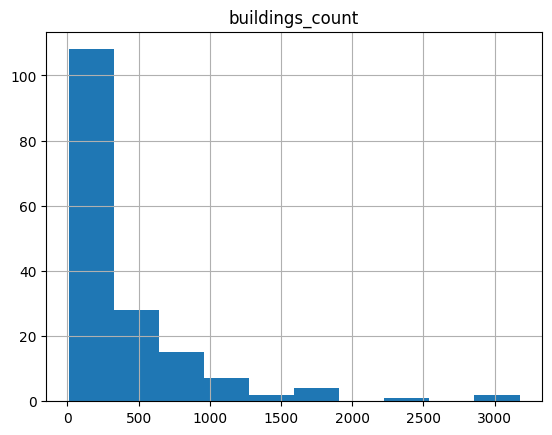

In [140]:
renabap_la_plata.hist("buildings_count")

How does this compare to the number of families estimated by RENABAP itself? To start, we can simply divide the number of total buildings by the number of families estimated by RENABAP.

In [142]:
print(
    renabap_la_plata["buildings_count"].sum()
    / renabap_la_plata["familias_aproximadas"].sum()
)

1.8905757155911918


Interesting--our building footprints data suggest that there are almost _two_ building footprints for every family estimated by RENABAP. We can take this a step further and see if this pattern holds up across a full distribution:

In [146]:
renabap_la_plata["buildings_per_family"] = (
    renabap_la_plata["buildings_count"] / renabap_la_plata["familias_aproximadas"]
)

print(renabap_la_plata["buildings_per_family"].describe())

count    167.000000
mean       1.829345
std        0.950825
min        0.169713
25%        1.369318
50%        1.765625
75%        2.084886
max        9.621212
Name: buildings_per_family, dtype: float64


So, yes, on average, each settlement has 1.83 building footprint per family estimated by RENABAP. That raises some serious questions!

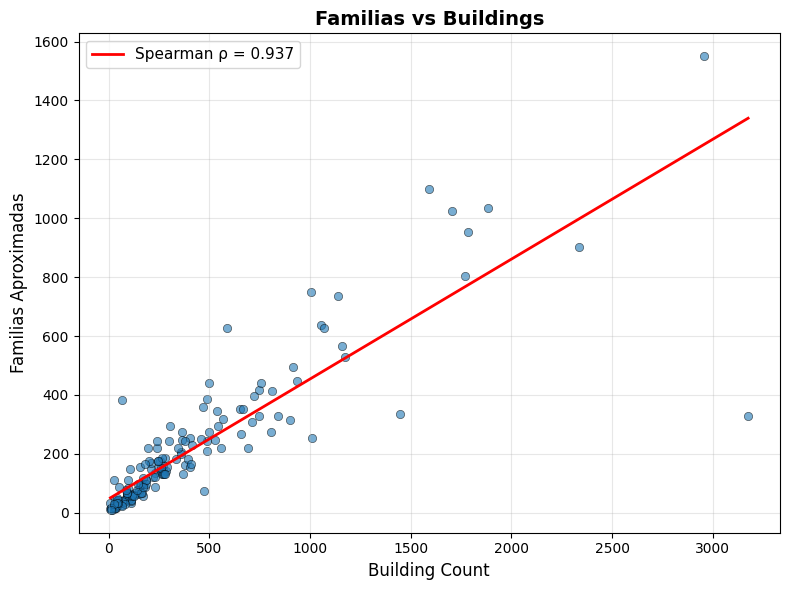

Spearman ρ = 0.9368
p-value = 3.80e-77


In [147]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot families vs buildings
ax.scatter(
    renabap_la_plata["buildings_count"],
    renabap_la_plata["familias_aproximadas"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)

# Spearman correlation
rho, p_value = stats.spearmanr(
    renabap_la_plata["buildings_count"], renabap_la_plata["familias_aproximadas"]
)

# Add regression line
slope, intercept = np.polyfit(
    renabap_la_plata["buildings_count"], renabap_la_plata["familias_aproximadas"], 1
)
x = np.array(
    [
        renabap_la_plata["buildings_count"].min(),
        renabap_la_plata["buildings_count"].max(),
    ]
)
ax.plot(x, intercept + slope * x, "r-", linewidth=2, label=f"Spearman ρ = {rho:.3f}")

ax.set_xlabel("Building Count", fontsize=12)
ax.set_ylabel("Familias Aproximadas", fontsize=12)
ax.set_title("Familias vs Buildings", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print stats
print(f"Spearman ρ = {rho:.4f}")
print(f"p-value = {p_value:.2e}")

It looks like there's a strong _correlation_ between the number of families estimated by RENABAP and the number of building footprints in our dataset. What this suggests is that the RENABAP estimates systematically underestimate household counts, potentially missing a lot of families. In fact, we can estimate exactly how many might be missing:

In [148]:
print(
    renabap_la_plata["buildings_count"].sum()
    - renabap_la_plata["familias_aproximadas"].sum()
)

30211


If we assume that each building footprint more or less corresponds to one family, and one family consists of an average of something like 3 people (it could well be more in informal settlements), then official RENABAP data may be missing something in the realm of 90.000 people in La Plata alone!

In [149]:
import contextily as cx

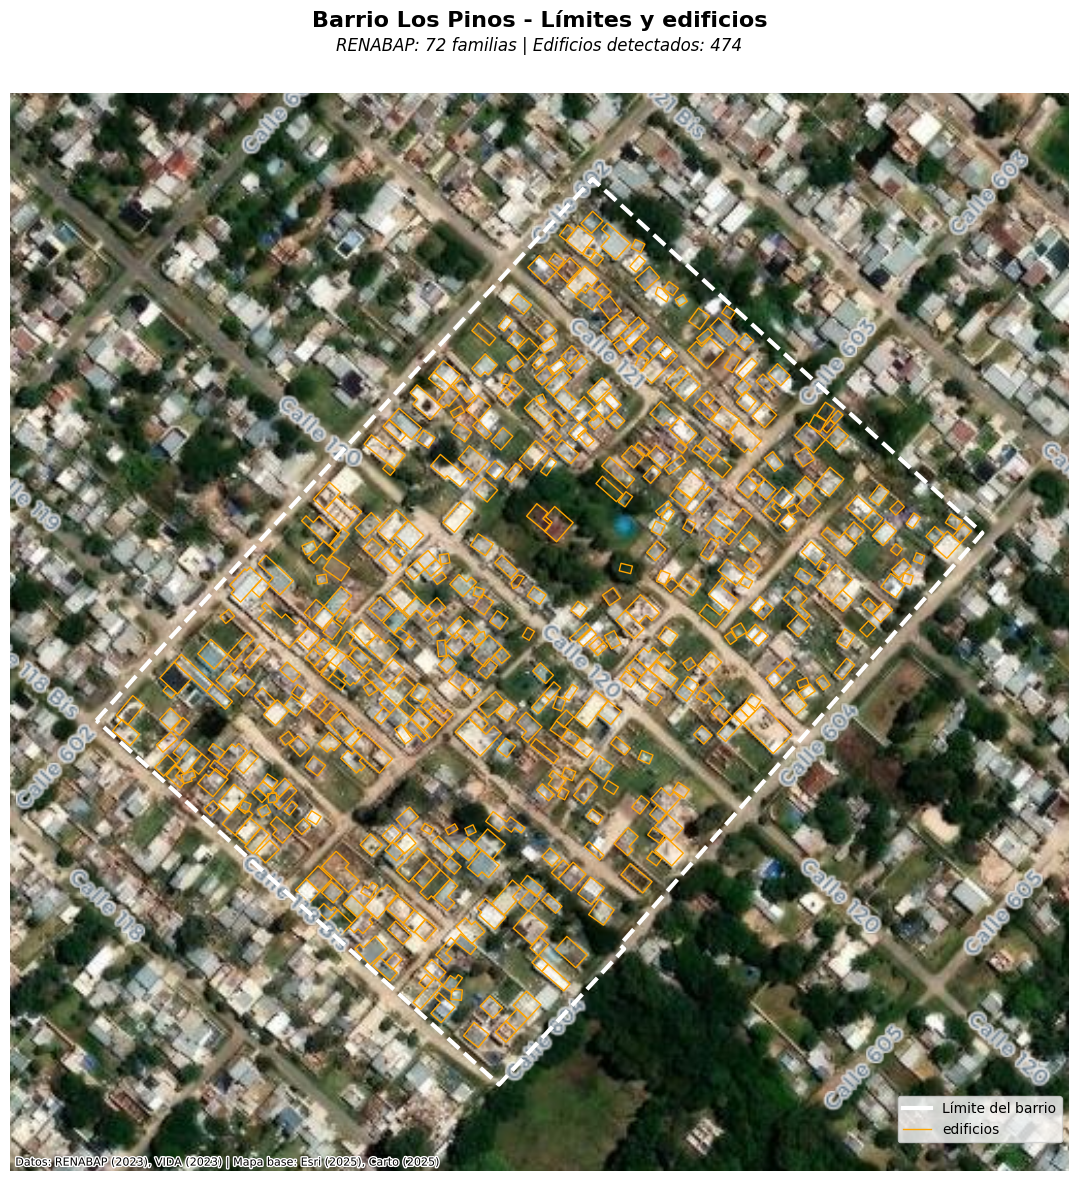

In [151]:
# | label: fig-ejemplo-barrio
# | fig-cap: "Ejemplo de discrepancia en los datos del RENABAP: el barrio Los Pinos con límites oficiales y edificios detectadas"

# Filtrar para obtener solo el barrio con id_renabap 5688
barrio_5688 = renabap_la_plata[renabap_la_plata["id_renabap"] == 5688].copy()
if len(barrio_5688) == 0:
    print("No se encontró el barrio con id_renabap 5688")
else:
    # Obtener edificios en este barrio
    buildings_5688 = buildings_in_barrios[
        buildings_in_barrios["id_renabap"] == 5688
    ].copy()
    # Convertir a Web Mercator
    barrio_5688_3857 = barrio_5688.to_crs(WEB_MERCATOR_CRS)
    buildings_5688_3857 = buildings_5688.to_crs(WEB_MERCATOR_CRS)
    # Crear el mapa
    fig, ax = plt.subplots(figsize=(12, 12))
    # Configurar límites basados en el barrio
    bounds = barrio_5688_3857.total_bounds
    margin = 50  # metros
    ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
    ax.set_ylim(bounds[1] - margin, bounds[3] + margin)
    # Agregar basemap de contextily
    cx.add_basemap(
        ax,
        crs=WEB_MERCATOR_CRS,
        source=cx.providers.Esri.WorldImagery,
        attribution="Datos: RENABAP (2023), VIDA (2023) | Mapa base: Esri (2025), Carto (2025)",
    )
    # Plot de edificios con contorno naranja (sin fill)
    buildings_5688_3857.plot(ax=ax, facecolor="none", edgecolor="orange", linewidth=1)
    # Plot del límite del barrio con estilo consistente
    barrio_5688_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="white",  # White for satellite imagery visibility
        linewidth=3,
        linestyle="--",
        zorder=10,
    )

    cx.add_basemap(
        ax,
        crs=WEB_MERCATOR_CRS,
        source=cx.providers.CartoDB.PositronOnlyLabels,
        attribution="",
    )

    # Limpiar el mapa
    barrio_nombre = barrio_5688["nombre_barrio"].iloc[0]
    familias_renabap = int(barrio_5688["familias_aproximadas"].iloc[0])
    total_edificios = len(buildings_5688)

    # Título principal usando suptitle
    fig.suptitle(
        f"Barrio {barrio_nombre} - Límites y edificios",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )

    # Subtítulo usando title
    ax.set_title(
        f"RENABAP: {familias_renabap} familias | Edificios detectados: {total_edificios}",
        fontsize=12,
        style="italic",
        pad=30,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Agregar leyenda simple
    legend_elements = [
        plt.Line2D([0], [0], color="white", linewidth=3, label="Límite del barrio"),
        plt.Line2D(
            [0],
            [0],
            color="orange",
            linewidth=1,
            label="edificios",
        ),
    ]
    ax.legend(handles=legend_elements, loc="lower right", bbox_to_anchor=(1.0, 0.02))
    plt.tight_layout()
    plt.show()

So this raises some big questions about the reliability of the official RENABAP estimates. It looks like they tend to underestimate the population per settlement by a factor of almost two! Which means that, if we assume an average family size around 3, we could be talking about 100,000 or more people not accounted for in official data.

So what would we do with this information? Well, real action would require us to go out and do more validation of these data. And there should probably be scientific studies done to further understand what's going on. But this shows us the power of these data!

We actually would need to really establish this uncertainty. We would actually need to go out and visit some of these informal settlements and get a sense of how accurate the buildings of prints are.

We would need to do a better census of the informal settlements, which obviously is outside the scope of the study.